<a href="https://colab.research.google.com/github/EmmaCOo/Prediction-of-Spotify-App-Reviews-Sentiment-Analysis-/blob/main/SpotifyNLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**Spotify App Reviews Sentiment Analysis**
https://www.kaggle.com/datasets/mfaaris/spotify-app-reviews-2022



In [53]:
# import libraries

import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, StandardScaler, Normalizer
from sklearn.metrics import confusion_matrix, accuracy_score, plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

from collections import Counter
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
import string
from nltk.tokenize import word_tokenize
import re


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


###LOAD DATA SET

In [54]:
df = pd.read_csv('/content/drive/MyDrive/reviews.csv')
df.head()

,Time_submitted,Review,Rating,Total_thumbsup,Reply
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,NaN


### DROP INSIGNIFICANT COLUMN

In [55]:
# drop # column
df = df.drop(columns = ['Time_submitted','Total_thumbsup','Reply'])
df.head()

,Review,Rating
0,"Great music service, the audio is high quality...",5
1,Please ignore previous negative rating. This a...,5
2,"This pop-up ""Get the best Spotify experience o...",4
3,Really buggy and terrible to use as of recently,1
4,Dear Spotify why do I get songs that I didn't ...,1


### INVESTIGATION OF THE DATASET 

In [56]:
# dimension of the data
print(df.shape)

# missing values
print(df.isna().sum())

(61594, 2)
Review    0
Rating    0
dtype: int64


In [57]:
# drop all the records with missing values
df = df.dropna()

print(df.isna().sum())

Review    0
Rating    0
dtype: int64


In [58]:
# check duplicate records
print(df.duplicated().sum())

# drop the duplicates
df.drop_duplicates(keep = False, inplace = True)

201


In [59]:
# check again for the duplicate
print(df.duplicated().sum())

0


In [60]:
# shape of the transfomred data
df.shape

(61287, 2)

###VISUALIZATION OF THE COLUMNS 'COMPANY' AND 'RATING'

###DISTRIBUTION OF THE TARGET CLASS 'RATING'

Text(0.5, 1.0, 'Distribution of Target Classes')

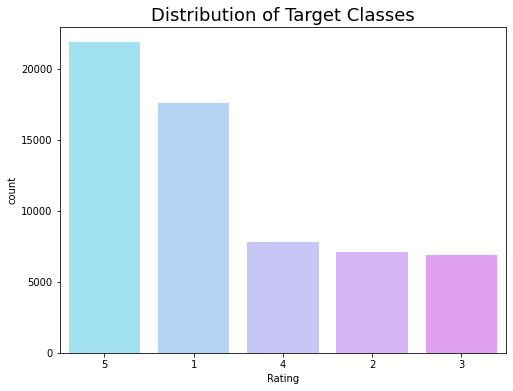

In [61]:
# Figur size
plt.figure(figsize=(8,6))

# countplot
sns.countplot( x = 'Rating', data = df, palette = 'cool', alpha = 0.5, order = df['Rating'].value_counts().index)

# Add title
plt.title('Distribution of Target Classes', fontsize=18)

###Since class-imbalance was observed, let's balance the target classes. 

In [62]:
#Downsample class 5 and 1 as reference class, rating 4
rating_5 = df[df['Rating'] == 5]  #reference class 
rating_4 = df[df['Rating'] == 4]  
rating_3 = df[df['Rating'] == 3]
rating_2 = df[df['Rating'] == 2]  
rating_1 = df[df['Rating'] == 1]
print(rating_5.shape, rating_4.shape, rating_3.shape, rating_2.shape, rating_1.shape)

(21862, 2) (7826, 2) (6879, 2) (7111, 2) (17609, 2)


In [63]:
from sklearn.utils import resample
r2_downsample = resample(rating_2,replace=True,n_samples=len(rating_5),random_state=42)

r3_downsample = resample(rating_3,replace=True,n_samples=len(rating_5),random_state=42)

r4_downsample = resample(rating_4,replace=True,n_samples=len(rating_5),random_state=42)


In [64]:
#create a new dataframe with balanced datasets
frames = rating_1, r2_downsample, r3_downsample, r4_downsample, rating_5
new_df = pd.concat(frames)
new_df.shape

(105057, 2)

Text(0.5, 1.0, 'Distribution of Target Classes After Balancing')

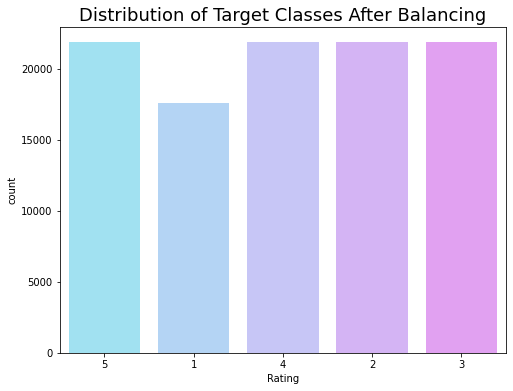

In [65]:
# Figur size
plt.figure(figsize=(8,6))
# countplot
sns.countplot( x = 'Rating', data = new_df, palette = 'cool', alpha = 0.5, order = df['Rating'].value_counts().index)
# Add title
plt.title('Distribution of Target Classes After Balancing', fontsize=18)

###**PREPROCESSING OF FEATURE COLUMN 'REVIEWS'**

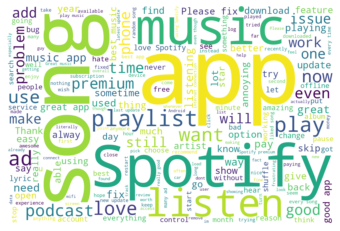

In [66]:
# Generating a word cloud of frequency of text
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white", width=1500, height=1000).generate(' '.join(df['Review']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

###**REMOVE PUNCTUATION**

In [67]:
import string
string.punctuation   # print lists of punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [68]:
# Function to remove punctuation
def remove_punc(text):
  text_nonpunc ="".join([char for char in str(text) if char not in string.punctuation])
  return text_nonpunc

# applyiing remove_punc function into 'narrative' and saving as a 'no_punctuation' column
new_df['no_punctuation'] = new_df['Review'].apply(lambda x: remove_punc(x))

new_df.head()

,Review,Rating,no_punctuation
3,Really buggy and terrible to use as of recently,1,Really buggy and terrible to use as of recently
4,Dear Spotify why do I get songs that I didn't ...,1,Dear Spotify why do I get songs that I didnt p...
9,"I'm deleting this app, for the following reaso...",1,Im deleting this app for the following reasons...
11,Can't play Spotify when on WiFi,1,Cant play Spotify when on WiFi
12,I had amazon premium music family package and ...,1,I had amazon premium music family package and ...


In [69]:
#function to tokenize the text
def tokenize(text):
  tokens = re.split('\W+', text)
  return tokens

# add new column 'tokenized' to df
new_df['tokenized'] = new_df['no_punctuation'].apply(lambda x: tokenize(x)) # convert lower case to all words

new_df.head()

,Review,Rating,no_punctuation,tokenized
3,Really buggy and terrible to use as of recently,1,Really buggy and terrible to use as of recently,"[Really, buggy, and, terrible, to, use, as, of..."
4,Dear Spotify why do I get songs that I didn't ...,1,Dear Spotify why do I get songs that I didnt p...,"[Dear, Spotify, why, do, I, get, songs, that, ..."
9,"I'm deleting this app, for the following reaso...",1,Im deleting this app for the following reasons...,"[Im, deleting, this, app, for, the, following,..."
11,Can't play Spotify when on WiFi,1,Cant play Spotify when on WiFi,"[Cant, play, Spotify, when, on, WiFi]"
12,I had amazon premium music family package and ...,1,I had amazon premium music family package and ...,"[I, had, amazon, premium, music, family, packa..."


In [70]:
# lists of stopwords
stopword = nltk.corpus.stopwords.words('english')
print(stopword)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [71]:
import spacy
#loading the english language small model of spacy
en = spacy.load('en_core_web_sm')
sw_spacy = en.Defaults.stop_words
print(sw_spacy)

{'mostly', 'for', 'without', 'i', 'name', 'he', 'somehow', 'as', 'during', 'just', '’m', 'may', 'n‘t', 'neither', 'in', 'below', 'nor', 'nobody', 'really', 'before', 'also', 'but', 'every', 'take', 'therein', 'did', "'ve", 'two', 'done', 'so', 'this', 'some', 'whereas', 'she', 'thereafter', 'themselves', 'therefore', 'an', 'several', 'former', 're', 'serious', "'re", 'between', 'across', 'been', 'anyway', 'perhaps', 'front', 'towards', 'most', 'had', 'sometimes', 'from', 'wherein', 'ourselves', 'you', 'four', 'why', 'within', 'except', 'hereby', 'around', 'do', 'will', 'somewhere', 'everything', 'should', 'own', 'was', 'ca', 'one', 'whither', 'using', 'anywhere', 'what', 'would', 'throughout', 'see', 'were', 'anyhow', 'alone', 'yours', 'seemed', 'unless', 'or', 'that', 'empty', 'off', 'make', 'sixty', "'s", 'everyone', 'itself', 'on', 'thru', 'wherever', 'moreover', 'three', 'bottom', 'too', 'move', 'whose', 'does', 'cannot', 'her', 'top', 'seeming', 'whence', 'nothing', 'others', '‘d'

In [72]:
# function to remove stopwords
def remove_sw(tokenized_list):
  func_sw = [word for word in tokenized_list if word not in sw_spacy]
  return func_sw

# add new column 'no_stopword' to df
new_df['no_stopword'] = new_df['tokenized'].apply(lambda x: remove_sw(x))

new_df.head()

,Review,Rating,no_punctuation,tokenized,no_stopword
3,Really buggy and terrible to use as of recently,1,Really buggy and terrible to use as of recently,"[Really, buggy, and, terrible, to, use, as, of...","[Really, buggy, terrible, use, recently]"
4,Dear Spotify why do I get songs that I didn't ...,1,Dear Spotify why do I get songs that I didnt p...,"[Dear, Spotify, why, do, I, get, songs, that, ...","[Dear, Spotify, I, songs, I, didnt, playlist, ..."
9,"I'm deleting this app, for the following reaso...",1,Im deleting this app for the following reasons...,"[Im, deleting, this, app, for, the, following,...","[Im, deleting, app, following, reasons, This, ..."
11,Can't play Spotify when on WiFi,1,Cant play Spotify when on WiFi,"[Cant, play, Spotify, when, on, WiFi]","[Cant, play, Spotify, WiFi]"
12,I had amazon premium music family package and ...,1,I had amazon premium music family package and ...,"[I, had, amazon, premium, music, family, packa...","[I, amazon, premium, music, family, package, g..."


In [73]:
lm = nltk.WordNetLemmatizer()

def lemmat(tokenized_text):
  text = [lm.lemmatize(word) for word in tokenized_text]
  return text

# add new column 'lemmatized' to df
new_df['lemmatized'] = new_df['no_stopword'].apply(lambda x: lemmat(x))

new_df.head()

,Review,Rating,no_punctuation,tokenized,no_stopword,lemmatized
3,Really buggy and terrible to use as of recently,1,Really buggy and terrible to use as of recently,"[Really, buggy, and, terrible, to, use, as, of...","[Really, buggy, terrible, use, recently]","[Really, buggy, terrible, use, recently]"
4,Dear Spotify why do I get songs that I didn't ...,1,Dear Spotify why do I get songs that I didnt p...,"[Dear, Spotify, why, do, I, get, songs, that, ...","[Dear, Spotify, I, songs, I, didnt, playlist, ...","[Dear, Spotify, I, song, I, didnt, playlist, A..."
9,"I'm deleting this app, for the following reaso...",1,Im deleting this app for the following reasons...,"[Im, deleting, this, app, for, the, following,...","[Im, deleting, app, following, reasons, This, ...","[Im, deleting, app, following, reason, This, a..."
11,Can't play Spotify when on WiFi,1,Cant play Spotify when on WiFi,"[Cant, play, Spotify, when, on, WiFi]","[Cant, play, Spotify, WiFi]","[Cant, play, Spotify, WiFi]"
12,I had amazon premium music family package and ...,1,I had amazon premium music family package and ...,"[I, had, amazon, premium, music, family, packa...","[I, amazon, premium, music, family, package, g...","[I, amazon, premium, music, family, package, g..."


In [74]:
new_df['length_before_cleaning'] = new_df['Review'].apply(lambda x: len(x))  # length of raw texts
new_df['length_after_cleaning'] = new_df['lemmatized'].apply(lambda x: len(x))  # length of cleand words
new_df.head()

,Review,Rating,no_punctuation,tokenized,no_stopword,lemmatized,length_before_cleaning,length_after_cleaning
3,Really buggy and terrible to use as of recently,1,Really buggy and terrible to use as of recently,"[Really, buggy, and, terrible, to, use, as, of...","[Really, buggy, terrible, use, recently]","[Really, buggy, terrible, use, recently]",47,5
4,Dear Spotify why do I get songs that I didn't ...,1,Dear Spotify why do I get songs that I didnt p...,"[Dear, Spotify, why, do, I, get, songs, that, ...","[Dear, Spotify, I, songs, I, didnt, playlist, ...","[Dear, Spotify, I, song, I, didnt, playlist, A...",100,10
9,"I'm deleting this app, for the following reaso...",1,Im deleting this app for the following reasons...,"[Im, deleting, this, app, for, the, following,...","[Im, deleting, app, following, reasons, This, ...","[Im, deleting, app, following, reason, This, a...",443,43
11,Can't play Spotify when on WiFi,1,Cant play Spotify when on WiFi,"[Cant, play, Spotify, when, on, WiFi]","[Cant, play, Spotify, WiFi]","[Cant, play, Spotify, WiFi]",31,4
12,I had amazon premium music family package and ...,1,I had amazon premium music family package and ...,"[I, had, amazon, premium, music, family, packa...","[I, amazon, premium, music, family, package, g...","[I, amazon, premium, music, family, package, g...",430,42


In [75]:
# Top 10 Most Used Words from the raw narrative column
from collections import Counter
count = Counter(" ".join(new_df["Review"]).split()).most_common(10)
print(count)


[('the', 123177), ('to', 119408), ('I', 108691), ('and', 81358), ('it', 64896), ('a', 60977), ('is', 51781), ('app', 45310), ('my', 40341), ('of', 38596)]


In [76]:
raw_top = pd.DataFrame(count, columns = ['Words','Frequency'])
raw_top

,Words,Frequency
0,the,123177
1,to,119408
2,I,108691
3,and,81358
4,it,64896
5,a,60977
6,is,51781
7,app,45310
8,my,40341
9,of,38596


In [77]:
reviews = new_df["lemmatized"].values.tolist()
flat_list = [item for elem in reviews for item in elem if str(item) != 'nan']

fdist1 = nltk.FreqDist(flat_list)
lem_top = pd.DataFrame(fdist1.most_common(10), columns = ['Words','Frequency'])
lem_top


,Words,Frequency
0,I,109133
1,song,61024
2,app,58421
3,music,38975
4,play,24476
5,Spotify,23514
6,ad,18865
7,like,18081
8,playlist,16444
9,listen,15757


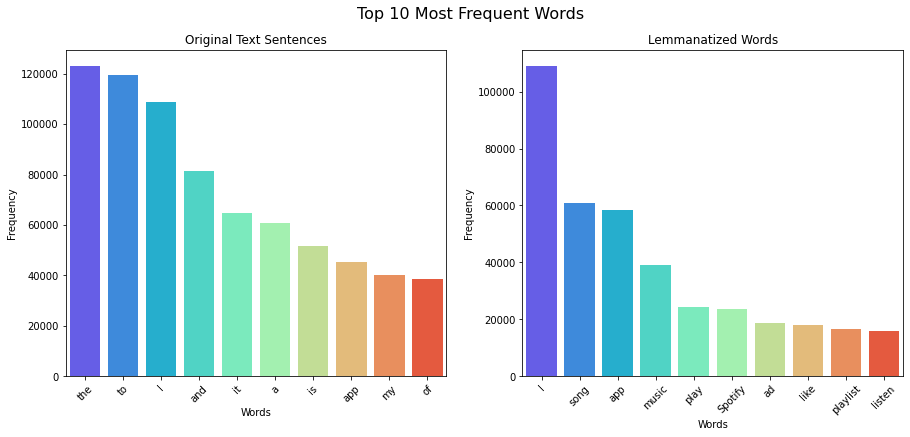

In [78]:
fig, ax = plt.subplots(1,2, figsize=(15,6))
fig.suptitle('Top 10 Most Frequent Words', size = 16)

sns.barplot(x='Words', y= 'Frequency', data = raw_top , palette = 'rainbow', ax = ax[0])
sns.barplot(x='Words', y= 'Frequency', data = lem_top , palette = 'rainbow', ax = ax[1])

ax[0].set_title('Original Text Sentences')
ax[1].set_title('Lemmanatized Words')

ax[0].tick_params(axis='x', labelrotation = 45)
ax[1].tick_params(axis='x', labelrotation = 45)
fig.show()

### FIND EACH RATING AND MOST RELATED WORDS

In [79]:
# split df - positive and negative sentiment:
positive = new_df[new_df['Rating'] == 5]
negative = new_df[new_df['Rating'] == 1]

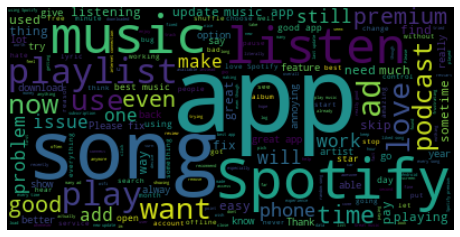

In [80]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


# Create stopword list:
stopwords = set(STOPWORDS)

plt.figure(figsize=(8,10))

textt = " ".join(review for review in df.Review)
wordcloud = WordCloud(stopwords=stopwords).generate(textt)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud11.png')
plt.show()

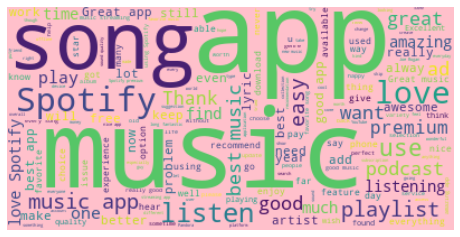

In [81]:
plt.figure(figsize=(8,10))

stopwords = set(STOPWORDS)

pos = " ".join(review for review in positive.Review)

wc = WordCloud(stopwords = STOPWORDS,
               background_color = "pink",
               max_words = 2000,
               max_font_size = 100,
               random_state = 42)
wordcloud2 = wc.generate(pos)
plt.imshow(wordcloud2, interpolation='bilinear')

plt.axis("off")
plt.show()

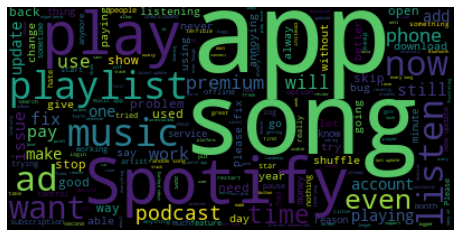

In [82]:
plt.figure(figsize=(8,8))

neg = " ".join(review for review in negative.Review)

wc = WordCloud(stopwords = STOPWORDS,
               background_color = "black",
               max_words = 2000,
               max_font_size = 100,
               random_state = 42)
wordcloud2 = wc.generate(neg)

plt.imshow(wordcloud2, interpolation='bilinear')

plt.axis("off")
plt.show()

### **DATA PARTITIONING** 

In [83]:
# clean data frame with only 'Review' and 'lemmatized' columns
spotify = new_df[['Rating', 'lemmatized']]

# split feature and target column
X = spotify['lemmatized']
y = spotify['Rating']

print(X.head(), y.head())

3              [Really, buggy, terrible, use, recently]
4     [Dear, Spotify, I, song, I, didnt, playlist, A...
9     [Im, deleting, app, following, reason, This, a...
11                          [Cant, play, Spotify, WiFi]
12    [I, amazon, premium, music, family, package, g...
Name: lemmatized, dtype: object 3     1
4     1
9     1
11    1
12    1
Name: Rating, dtype: int64


### **VECTORIZATION**



In [84]:
# Vectorization

# for train data set
vectorizer = TfidfVectorizer()
X_vec = vectorizer.fit_transform(X.astype(str))

# get feature names
feat_names = vectorizer.get_feature_names()

# create da data frame called X from bag of words features
X_tf = pd.DataFrame.sparse.from_spmatrix(X_vec, columns = feat_names)
X_tf.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,00,000,0000,0000000001,0001,0003,000348,0005,0009,001,...,𝚎𝚟𝚎𝚛,𝚑𝚊𝚟𝚎,𝚒𝚜,𝚕𝚘𝚟𝚎𝚍,𝚖𝚘𝚜𝚝,𝚖𝚞𝚜𝚒𝚌,𝚝𝚑𝚎,𝚝𝚑𝚒𝚗𝚔,𝚝𝚑𝚒𝚜,𝟐𝐱
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [85]:
# train(70%) and test (30%) splitting with stratified samples
X_train, X_test, y_train, y_test = train_test_split(X_tf,y, test_size = 0.3, random_state = 42, stratify = y)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((73539, 28346), (73539,), (31518, 28346), (31518,))

###**MODELS**

###**RANDOM FOREST**

####**RF WITHOUT TUNING**

In [86]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train,y_train)

rf_pred= rf.predict(X_test)

print(accuracy_score(y_test, rf_pred))

0.8715019988577956


####**RF HYPERPARAMETER TUNINGS**

In [87]:
#import warnings
#warnings.filterwarnings("ignore")

train_errors = list()
test_errors = list()

for i in range(1,20):
  rf_model = RandomForestClassifier(max_depth=i)    #Create multiple models here each based on the i variable above
  rf_model.fit(X_train,y_train)
  train_pred = rf_model.predict(X_train)
  test_pred = rf_model.predict(X_test)
  train_errors.append(accuracy_score(y_train,train_pred))    # Store the result of modes in t_train_erors and t_test_errors variables
  test_errors.append(accuracy_score(y_test, test_pred))
 

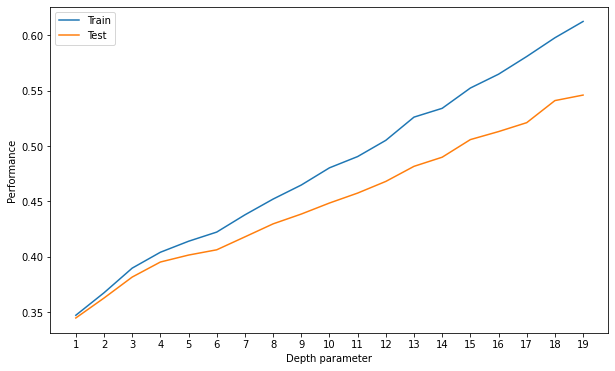

In [88]:
# Plot of test and training errors
fig,ax = plt.subplots(figsize=(10,6))
plt.plot(range(1,20),train_errors, label='Train')
plt.plot(range(1,20),test_errors, label='Test')
plt.legend(loc='upper left')
plt.xlabel('Depth parameter')
plt.ylabel('Performance')
plt.xticks(ticks =np.arange(1, 20, 1));

In [101]:
tuned_rf= RandomForestClassifier(max_depth=80)
tuned_rf.fit(X_train,y_train)

tuned_rf_pred= tuned_rf.predict(X_test)

print(accuracy_score(y_test, tuned_rf_pred))

0.8117900882035662


####**KNN**

####**KNN WITHOUT TUNING**

In [90]:
from sklearn.neighbors import KNeighborsClassifier


knn = KNeighborsClassifier()
knn = knn.fit(X_train, y_train)

knn_pred = knn.predict(X_test)

print(accuracy_score(y_test, knn_pred))

0.5903927914207754


####**KNN HYPERPARAMETER TUNING**

In [91]:
# create and test a KNN model

def k_neighbors(xtrain, ytrain, xtest, ytest, kvalues, metric):
  knn_accuracy = []
  clfs = []
  for i in kvalues:
    clf = KNeighborsClassifier(metric=metric, n_neighbors=i).fit(xtrain, ytrain) # KNN models with i numbers of kvalues
    clf_train_pred = clf.predict(xtrain)  # prediction of train set
    clf_test_pred = clf.predict(xtest)  # prediction of test set
    clfs.append(clf)  # append the models
    knn_accuracy.append({'k values': i,   # append k values, accuracies of train and test
    'Training Accuracy':accuracy_score(clf_train_pred,ytrain),
    'Test Accuracy': accuracy_score(clf_test_pred,ytest)})
  return pd.DataFrame(knn_accuracy), clfs

In [92]:
# Train and Test Accuracies with k values (1:10) with Euclidean distance
knn_euc_acc, knn_euc_clfs = k_neighbors(X_train, y_train, X_test, y_test, range(1,20,2), 'euclidean')   
display(knn_euc_acc)

,k values,Training Accuracy,Test Accuracy
0,1,0.997253,0.782886
1,3,0.844817,0.663430
2,5,0.747658,0.590393
3,7,0.677844,0.541595
4,9,0.630101,0.512342
5,11,0.595113,0.496859
6,13,0.571819,0.487721
7,15,0.555120,0.480170
8,17,0.543399,0.472079
9,19,0.534832,0.466844


### KNN ACCURACY PLOT WITH EUCLIDEAN DISTANCE FOR TRAIN AND TEST DATA 


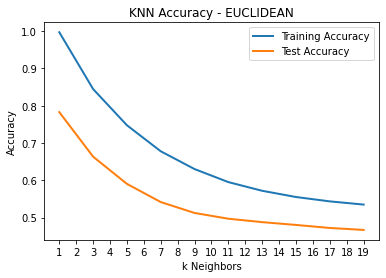

In [93]:
kvalues = range(1,20)

plt.plot(knn_euc_acc['k values'], knn_euc_acc['Training Accuracy'],linewidth=2, label='Training Accuracy')
plt.plot(knn_euc_acc['k values'], knn_euc_acc['Test Accuracy'],linewidth=2, label='Test Accuracy')
plt.xlabel('k Neighbors')
plt.ylabel('Accuracy')
plt.title('KNN Accuracy - EUCLIDEAN')
plt.xticks(np.arange(min(kvalues),max(kvalues)+1, 1))
plt.legend()
plt.show()
# as the k-neighbors increase, there's so significant scores difference between test and train data anymore due to underfitting.

In [94]:
knn_clf = KNeighborsClassifier(n_neighbors = 3)

knn_clf.fit(X_train, y_train)

knn_clf_pred = knn_clf.predict(X_test)

print(accuracy_score(y_test, knn_clf_pred))

0.6634304207119741


###**Naives Bayes**

In [95]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB().fit(X_train, y_train)

nb_pred = nb.predict(X_test)

print(accuracy_score(y_test, nb_pred))

0.5612665778285424


In [102]:
labels = [1,2,3,4,5]

models = [rf_pred, tuned_rf_pred, knn_pred, nb_pred]
accuracy = []

for i in models: 
  accuracy_scores = accuracy_score(i,y_test)
  accuracy.append(accuracy_scores)

In [103]:
# merge accuracy and f1_scores dataframe
accuracy = pd.DataFrame(accuracy, columns = ['Accuracy_score'])
accuracy_table = accuracy.round(decimals = 2)

accuracy_table.insert(0, 'Models', ['Random Forest','Tuned Random Forest', 'KNN','Navies Bayes'])
accuracy_table

,Models,Accuracy_score
0,Random Forest,0.87
1,Tuned Random Forest,0.81
2,KNN,0.59
3,Navies Bayes,0.56


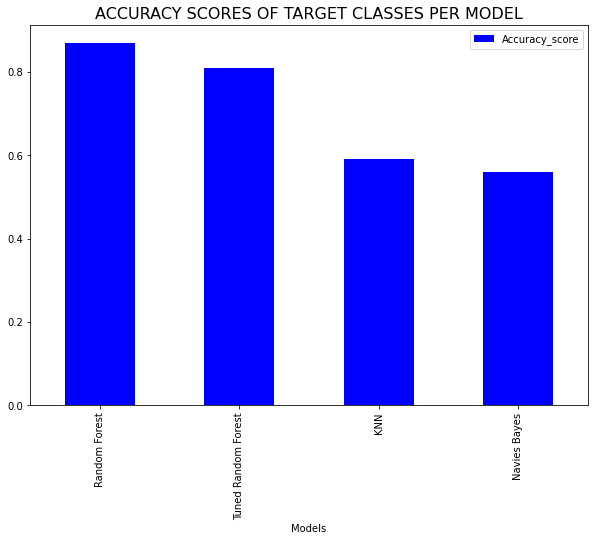

In [104]:
#Bargraph for Comparison of Accuracy for Each Model

accuracy_table.plot(x="Models", y= ['Accuracy_score'], kind = 'bar',figsize = (10,7), colormap = 'winter')
plt.title('ACCURACY SCORES OF TARGET CLASSES PER MODEL', size = 16)
plt.show()

###**Random Forest models outperform better than kNN model and Naives Bayes.**